# Import 

In [143]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


# Consts

In [144]:
Z_DIM = 128 # latent dim used
EPOCHS = 3 # number of epochs
LEARNING_RATE = 0.0001 # learning rate
BATCH_SIZE = 64 # size of batches

# Load and Process the Data

In [145]:
# load the dataset
data = np.load("../data/full_numpy_bitmap_flower.npy")

In [146]:
#reshape and normalize images
data = data.reshape((-1, 28, 28, 1))
data = data.astype("float32") / 255
data = data[:]
data.shape

(144818, 28, 28, 1)

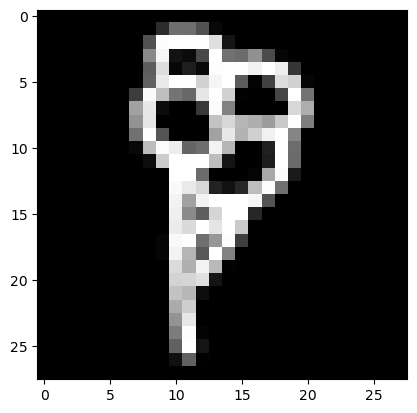

In [147]:
# showing an image
plt.imshow(data[np.random.choice(len(data))],cmap="gray")

In [148]:
from tensorflow.keras import layers,models

# Create the Critic 
the discriminator has become a critic.The difference between these two things is that the drisciminator 
performs a classification while the critic just gives a score on ]−∞;+∞[ (no sigmoid)
+∞ = real
−∞ = fake


In [149]:
critic_input  = layers.Input(shape=(28, 28, 1))
x                   = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(critic_input)
x                   = layers.LeakyReLU(alpha=0.2)(x)
x                   = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x                   = layers.LeakyReLU(alpha=0.2)(x)
x                   = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x                   = layers.LeakyReLU(alpha=0.2)(x)
x                   = layers.Flatten()(x)
x                   = layers.Dropout(0.2)(x)
critic_output       = layers.Dense(1)(x)

critic = models.Model(critic_input, critic_output, name="critic")
critic.summary()

Model: "critic"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_36 (Conv2D)          (None, 14, 14, 64)        1088      
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 conv2d_37 (Conv2D)          (None, 7, 7, 128)         131200    
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 conv2d_38 (Conv2D)          (None, 4, 4, 128)         262272    
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 4, 4, 128)         0    

# Create the Generator 

In [150]:
generator_input  = layers.Input(shape=(Z_DIM,))
x       = layers.Dense(7 * 7 * 64)(generator_input)
x       = layers.Reshape((7, 7, 64))(x)
x       = layers.UpSampling2D()(x)
x       = layers.Conv2D(128,  kernel_size=3, strides=1, padding='same', activation='relu')(x)
x       = layers.UpSampling2D()(x)
x       = layers.Conv2D(256,  kernel_size=3, strides=1, padding='same', activation='relu')(x)
generator_output = layers.Conv2D(1,    kernel_size=5, strides=1, padding="same", activation="sigmoid")(x)

generator = models.Model(generator_input, generator_output, name="generator")
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 128)]             0         
                                                                 
 dense_13 (Dense)            (None, 3136)              404544    
                                                                 
 reshape_6 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 up_sampling2d_12 (UpSampli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_39 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 up_sampling2d_13 (UpSampli  (None, 28, 28, 128)       0         
 ng2D)                                                   

In [151]:
from tensorflow.keras import metrics 

# Create the WDCGAN-GP Model

In [152]:
class DCGAN(models.Model):
    def __init__(self,my_critic,my_generator,z_dim=128,n_critic=3,lambda_gp=10,**kwargs):
        super(DCGAN,self).__init__(**kwargs)

        self.critic = my_critic
        self.generator = my_generator
        self.z_dim = z_dim
        self.latent_dim = z_dim
        self.n_critic = n_critic
        self.lambda_gp = lambda_gp
        
        self.critic_opt = None
        self.generator_opt = None
        self.loss_fn = None
        self.g_loss = None
        self.c_loss = None
        self.gp = None
        
    def call(self, inputs, training=None, mask=None):
        return self.generator(inputs)
    
    def compile(self,d_opt,g_opt):
        super(DCGAN,self).compile()
        self.critic_opt = d_opt
        self.generator_opt = g_opt
        self.critic.compile(optimizer=self.critic_opt)
        self.generator.compile(optimizer=self.generator_opt)
        self.c_loss = metrics.Mean(name="c_loss")
        self.g_loss = metrics.Mean(name="g_loss")
        self.gp = metrics.Mean(name="gp")
        
        
    @property
    def metrics(self):
        return [self.c_loss,self.g_loss,self.gp]
    
    def gradient_penalty(self,batch_size,real_images,fake_images):
        epsilon = tf.random.normal([batch_size,1,1,1],0.0,1.0)
        interpolated = fake_images+epsilon*(real_images-fake_images)
        
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            interpolated_critics = self.critic(interpolated,training=True)
        gradients = gp_tape.gradient(interpolated_critics,[interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(gradients),axis=[1,2,3]))
        gp = self.lambda_gp * tf.reduce_mean((norm-1.0)**2)
        return gp
    
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        
        #*****TRAIN THE CRITIC*****
        for i in range(self.n_critic):
            random_latent_vectors = tf.random.normal(shape=(batch_size,self.latent_dim))
            fake_images = self.generator(random_latent_vectors,training=True)
            with tf.GradientTape() as tape:
                
                # get critics for the fake images : D(G(z))
                fake_critics = self.critic(fake_images,training=True)
                
                # get  critics for the real images : D(x)
                real_critics = self.critic(real_images,training=True)
                
                # Calculate the wasserstein discriminator loss: L = D(fake)-D(real)
                w_loss = tf.reduce_mean(fake_critics) - tf.reduce_mean(real_critics)
                
                # Caluculate the gradient penalty
                gp = self.gradient_penalty(batch_size,real_images,fake_images)
                
                d_loss = w_loss + gp
                
            gradients = tape.gradient(d_loss,self.critic.trainable_weights)
            self.critic_opt.apply_gradients(zip(gradients,self.critic.trainable_weights))
            self.c_loss.update_state(d_loss)
            self.gp.update_state(gp)
          
        #*****TRAIN THE GENERATOR*****
        random_latent_vectors = tf.random.normal(shape=(batch_size,self.latent_dim))
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors,training=True)
            fake_critics = self.critic(fake_images)
            g_loss = -tf.reduce_mean(fake_critics)
        gradients = tape.gradient(g_loss,self.generator.trainable_variables)
        self.generator_opt.apply_gradients(zip(gradients,self.generator.trainable_variables))
        self.g_loss.update_state(g_loss)
        
       
        
        return {
            "c_loss": self.c_loss.result(),
            "g_loss": self.g_loss.result(),
            "gp":self.gp.result()
        }

In [153]:
from tensorflow.keras import optimizers
from utils.ImageGenerator import ImageGenerator

# Train the Model

In [154]:
dcgan = DCGAN(critic,generator,z_dim=Z_DIM)

In [155]:
c_opt = optimizers.legacy.Adam(learning_rate=LEARNING_RATE)
g_opt = optimizers.legacy.Adam(learning_rate=LEARNING_RATE)

dcgan.compile(c_opt,g_opt)

In [156]:
hist = dcgan.fit(data,batch_size=BATCH_SIZE,callbacks=ImageGenerator(10,Z_DIM,"callbacks"),epochs=EPOCHS)

Epoch 1/3



KeyboardInterrupt



# Save the Model

In [ ]:
dcgan.save("wdcgan-gp-qd-flower.keras")

# Generate Images

In [ ]:
nb_img = 5
z = np.random.normal(size=(nb_img, Z_DIM, 1))
predictions = dcgan.predict(z,verbose=False)

fig,axs = plt.subplots(1,nb_img)
for i in range(nb_img):
    axs[i].imshow(predictions[i],cmap="gray")
    axs[i].axis("off")
plt.tight_layout()
plt.show()
